In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import statsmodels.api as sm

# Need to move TRANSFORMERS and text_to_code_q6 to other script
from build_model_multinomial import TRANSFORMERS, text_to_code_q6, text_to_code_q10_2_binary, fallback_text_to_float, text_to_code_q10_2_binary_exclude_neither
from build_model_logistic import build_v2g_model_binary_from_df, run_single_feature_regressions, filter_significant_features
from get_data import init_column_map, pull_data_rowwise
from logistic_results_plot import (
    plot_feature_significance, 
    plot_odds_ratio_barh, 
    plot_p_value_barh, 
    plot_log_p_value_barh, 
    plot_coefficients_significance_barh, 
    plot_coefficient_vs_significance,
    plot_coefficients_barplot,
    plot_odds_ratios_barplot,
    plot_coefficients_by_abs,
    plot_binary_confusion_matrix,
    transform_and_plot_correlation
)

In [2]:
# Define all variable categories
from variables import (
    demographics, 
    input_variables_vehicle_ownership, 
    familiarity, 
    kms_driven, 
    renewables_at_home,
    parking, 
    q6a_cols, 
    energ_literacy, 
    renewables_at_home, 
    intent_to_purchase_vehicle,
    benefits_v2g, 
    concerns_v2g, 
    interest_in_services, 
    consider_using_NRMA_for,
    charging_control, 
    preference_on_batt_use, 
    expected_return,
    q6a_petrol, q6a_ev, q6a_plughyb, q6a_hybrid,
#     charging_control,
    feature_label_map
)

# 2. Model Setup

## 2.1. Initialise dataframe

In [3]:
csv_file = './data/survey_pre_processed_data.csv'

In [4]:
target_variable = 'Q10_2'  # "I would be interested in installing V2G..."

In [5]:
q10_2_categories = [
    "Strongly disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Strongly agree"
    ]

In [6]:
# Pull the data from CSV
init_column_map(csv_file)

columns_of_interest = (
    familiarity +
    kms_driven + 
    renewables_at_home + 
    q6a_cols + 
    demographics + 
    input_variables_vehicle_ownership + 
    parking + 
    benefits_v2g + 
    concerns_v2g +
    energ_literacy +
#   charging_control +
    [target_variable]
    )

rows = pull_data_rowwise(columns_of_interest, csv_file)

# Make a DataFrame
df = pd.DataFrame(rows, columns=columns_of_interest)
df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax1_2,Q6ax1_3,Q6ax2_1,Q6ax2_2,...,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3,5,5,,,...,1,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1,Very familiar,"Less than 10,000",1,1,0,5,5,5,5,5,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,Strongly agree
2,Not at all familiar,"20,001-50,000",0,0,1,2,1,2,,,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,Strongly disagree
3,Not at all familiar,"Less than 10,000",0,0,1,,,,,,...,0,0,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,Somewhat disagree
4,Very familiar,"20,001-50,000",1,1,0,5,5,5,4,4,...,0,1,0,0,0,0,Strongly agree,Strongly agree,Somewhat agree,Somewhat agree
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,,,,1,3,...,1,1,0,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,Strongly agree
1354,Somewhat familiar,"Less than 10,000",0,0,1,5,5,5,,,...,0,0,1,0,1,0,Strongly agree,Somewhat agree,Somewhat agree,Neither agree nor disagree
1355,Very familiar,"10,000-20,000",1,0,0,4,4,5,4,4,...,0,1,0,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,Strongly agree
1356,Very familiar,"10,000-20,000",0,0,1,,,,3,5,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Somewhat agree


## 2.2. Clean data

In [7]:
# Ensure "0 - Weekdays" is converted correctly
for col in q6a_cols:
    df[col] = df[col].replace("0 - Weekdays", 0)  # Convert "0 - Weekdays" to 0
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert all values to numbers

# Debugging: Check unique values in each column
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 4. 0. 1.]
Unique values in Q6ax1_2: [5. 1. 3. 2. 4. 0.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [5. 4. 3. 1. 2. 0.]
Unique values in Q6ax2_2: [5. 4. 3. 2. 0. 1.]
Unique values in Q6ax2_3: [5. 4. 3. 1. 0. 2.]
Unique values in Q6ax3_1: [3. 1. 4. 0. 2. 5.]
Unique values in Q6ax3_2: [5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [5. 2. 3. 0. 4. 1.]
Unique values in Q6ax4_3: [5. 3. 0. 1. 4. 2.]


In [8]:
# Count missing responses for each charging question
missing_counts = (df[q6a_cols] == 0).sum()
# Display summary of non-responses per column
print("Number of responses recorded as 0:")
print(missing_counts)

Number of responses recorded as 0:
Q6ax1_1    118
Q6ax1_2     28
Q6ax1_3     31
Q6ax2_1    102
Q6ax2_2     24
Q6ax2_3     14
Q6ax3_1      4
Q6ax3_2      0
Q6ax3_3      0
Q6ax4_1     12
Q6ax4_2      6
Q6ax4_3      9
dtype: int64


In [9]:
# Checking number of vehicles per type
print(df[q6a_petrol + q6a_ev + q6a_plughyb + q6a_hybrid].notna().sum())

Q6ax1_1    874
Q6ax1_2    874
Q6ax1_3    874
Q6ax2_1    768
Q6ax2_2    768
Q6ax2_3    768
Q6ax3_1     33
Q6ax3_2     33
Q6ax3_3     33
Q6ax4_1    111
Q6ax4_2    111
Q6ax4_3    111
dtype: int64


## 2.3. Update transformers to consider Q10_2 as binary (other than multinomial)

In [10]:
# Make a copy of TRANSFORMERS and update it with Q6a mappings
TRANSFORMERS_q6a = TRANSFORMERS.copy()

In [11]:
# Update with Q6a_* variables (charging behavior questions)
TRANSFORMERS_q6a.update({
    **{q: text_to_code_q6 for q in q6a_petrol},  
    **{q: text_to_code_q6 for q in q6a_ev},      
    **{q: text_to_code_q6 for q in q6a_plughyb}, 
    **{q: text_to_code_q6 for q in q6a_hybrid}   
})

In [12]:
TRANSFORMERS_q6a[target_variable] = text_to_code_q10_2_binary
TRANSFORMERS_q6a

{'Q1_1': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_2': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_3': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_4': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q1_99': <function build_model_multinomial.text_to_code_binary(raw_ans)>,
 'Q2': <function build_model_multinomial.text_to_code_q2(raw_ans)>,
 'Q3_1': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_2': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_3': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_4': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q3_5': <function build_model_multinomial.text_to_code_q3_parking(raw_ans)>,
 'Q7_1': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_2': <function build_model_multinomial.text_to_code_q7_likert(raw_ans)>,
 'Q7_3': <functio

# 3. Feature Selection - Univariate Logistic Regression Analysis

## 3.1. Full dataset

In [13]:
df[demographics]

,gender,colour_plus,region,Q20,Q21,Q22,AgeBand,Q24
0,Male,LILAC,METROPOLITAN,2,Freestanding house,Own outright,Prefer not to say,Prefer not to say
1,Male,LILAC,RURAL,2,Freestanding house,Own outright,Prefer not to say,Prefer not to say
2,Not Stated,KHAKI,INTERSTATE,2,Townhouse,Own outright,65+,"$1000-2000 a week / $52,000-$104,000 a year"
3,Male,PURPLE,METROPOLITAN,2,Freestanding house,Own outright,55-64 years,Prefer not to say
4,Male,PURPLE,INTERSTATE,3,Freestanding house,Own with mortgage,45-54 years,Prefer not to say
...,...,...,...,...,...,...,...,...
1353,Female,KHAKI,REGIONAL,2,Townhouse,Own outright,55-64 years,Prefer not to say
1354,Male,LILAC,REGIONAL,2,Apartment/unit,Own outright,65+,"$1000-2000 a week / $52,000-$104,000 a year"
1355,Male,GREY,REGIONAL,2,Freestanding house,Own outright,65+,"$2000-3000 a week / $104,000-$156,000 a year"
1356,Male,LILAC,RURAL,1,Other (please specify),Other (please specify),65+,"Less than $500 a week / Less than $26,000 a year"


In [14]:
features_to_select = (
    familiarity + 
    kms_driven +
    renewables_at_home +
    input_variables_vehicle_ownership + 
    q6a_petrol + 
    q6a_ev + 
    q6a_hybrid +
    q6a_plughyb +
    parking +
    benefits_v2g + 
    concerns_v2g + 
#   charging_control +
    energ_literacy
)

In [15]:
df[target_variable] = df[target_variable].apply(text_to_code_q10_2_binary)

# Ensure the target variable is binary (0 or 1)
df[target_variable] = df[target_variable].astype(int)

## 3.2. Vehicle at home habits

In [16]:
missing_q6a = df[q6a_cols].isna().sum()
print("Missing values per Q6a variable:\n", missing_q6a)

Missing values per Q6a variable:
 Q6ax1_1     484
Q6ax1_2     484
Q6ax1_3     484
Q6ax2_1     590
Q6ax2_2     590
Q6ax2_3     590
Q6ax3_1    1325
Q6ax3_2    1325
Q6ax3_3    1325
Q6ax4_1    1247
Q6ax4_2    1247
Q6ax4_3    1247
dtype: int64


In [17]:
df[q6a_cols] = df[q6a_cols].fillna(0)

In [18]:
for col in q6a_cols:
    print(f"Unique values in {col}: {df[col].dropna().unique()}")

Unique values in Q6ax1_1: [3. 5. 2. 0. 4. 1.]
Unique values in Q6ax1_2: [5. 1. 0. 3. 2. 4.]
Unique values in Q6ax1_3: [5. 2. 0. 4. 3. 1.]
Unique values in Q6ax2_1: [0. 5. 4. 3. 1. 2.]
Unique values in Q6ax2_2: [0. 5. 4. 3. 2. 1.]
Unique values in Q6ax2_3: [0. 5. 4. 3. 1. 2.]
Unique values in Q6ax3_1: [0. 3. 1. 4. 2. 5.]
Unique values in Q6ax3_2: [0. 5. 4. 2. 3. 1.]
Unique values in Q6ax3_3: [0. 5. 2. 3. 4.]
Unique values in Q6ax4_1: [0. 2. 5. 4. 3. 1.]
Unique values in Q6ax4_2: [0. 5. 2. 3. 4. 1.]
Unique values in Q6ax4_3: [0. 5. 3. 1. 4. 2.]


In [19]:
q6a_filters = {
    "petrol": (df["Q1_1"].astype(int) == 1),
    "ev": (df["Q1_2"].astype(int) == 1),
    "plug_hybrid": (df["Q1_3"].astype(int) == 1),
    "hybrid": (df["Q1_4"].astype(int) == 1),
}

## 3.3. Single feature regressions

In [20]:
df['Q8_1']

0       1
1       1
2       0
3       0
4       1
       ..
1353    1
1354    0
1355    1
1356    0
1357    1
Name: Q8_1, Length: 1358, dtype: object

In [ ]:
# IMPORTANT, THE CURRENT ANALYSIS IN THE PAPER DOESNT FIX THE FOLLOWING ISSUE
# BM: This has been updated

def binary_keep_zero(x):
    if pd.isna(x):          # treat missing as 0 for checkbox logic
        return 0
    s = str(x).strip().lower()
    if s in {"1", "yes", "true", "y"}:
        return 1
    if s in {"0", "no", "false", "n"}:
        return 0
    # last resort: numeric
    try:
        v = float(s)
        return 1 if v == 1 else 0
    except:
        return -1  # only truly invalid rows become -1

for c in ['Q8_1', 'Q8_2', 'Q8_99']:
    TRANSFORMERS_q6a[c] = binary_keep_zero

In [22]:
results_df = run_single_feature_regressions(
    df=df,
    features_to_select=features_to_select,
    target_variable="Q10_2",
    q6a_petrol=q6a_petrol,
    q6a_ev=q6a_ev,
    q6a_plughyb=q6a_plughyb,
    q6a_hybrid=q6a_hybrid,
    q6a_filters=q6a_filters,
    TRANSFORMERS_q6a=TRANSFORMERS_q6a,
    feature_label_map=feature_label_map
)

Running Logistic Regression for: Q9
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q2
Total rows before filter: 1358
Valid rows after filtering: 1355
Running Logistic Regression for: Q8_1
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q8_2
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q8_99
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q1_1
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q1_2
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q1_3
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q1_4
Total rows before filter: 1358
Valid rows after filtering: 1358
Running Logistic Regression for: Q1_99
Total rows before filter: 1358
Valid rows afte

In [23]:
results_df.to_csv('results_df.csv', index=False)

In [24]:
results_df

,Feature,Accuracy,Coefficient,Odds Ratio,P-value,abs_coef
34,Q14 - None of these,0.701031,-4.117509,0.016285,1.155364e-24,4.117509
6,Owns Electric Vehicle,0.765096,2.353804,10.525528,4.333243e-75,2.353804
27,Saving on my energy bill by using my car batte...,0.669367,1.427068,4.166465,3.144531e-35,1.427068
36,Safety concerns,0.602356,-1.288838,0.275591,2.825642e-16,1.288838
45,Q15 - None of these,0.591311,-1.267232,0.281610,6.529814e-14,1.267232
0,How Familiar Are You with V2G?,0.702504,1.199656,3.318973,1.707031e-54,1.199656
4,Owns Neither Solar nor Battery,0.643594,-1.191524,0.303758,6.820196e-25,1.191524
26,Earning money from my car battery by selling e...,0.586892,1.180903,3.257315,3.031615e-17,1.180903
2,Owns Solar Panels,0.642857,1.179113,3.251488,1.209640e-24,1.179113
41,Impact on my EV warranty,0.555965,1.144100,3.139613,2.535241e-12,1.144100


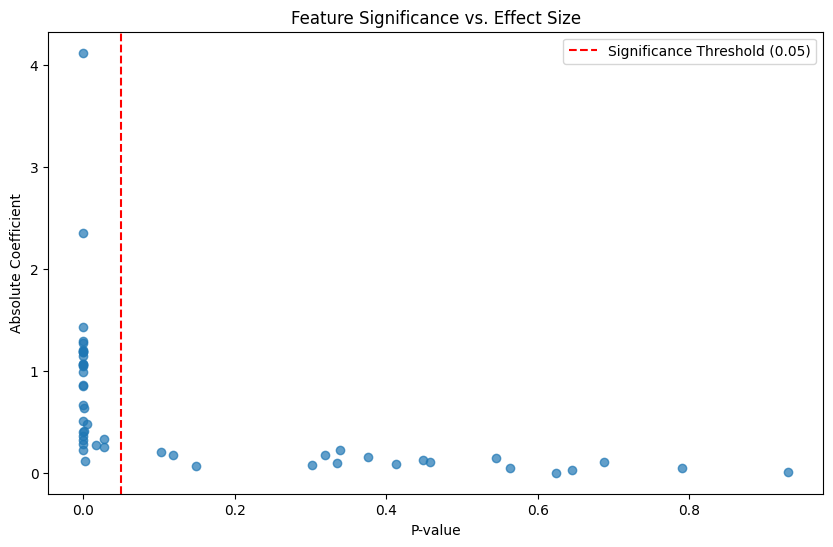

In [25]:
plot_feature_significance(results_df)

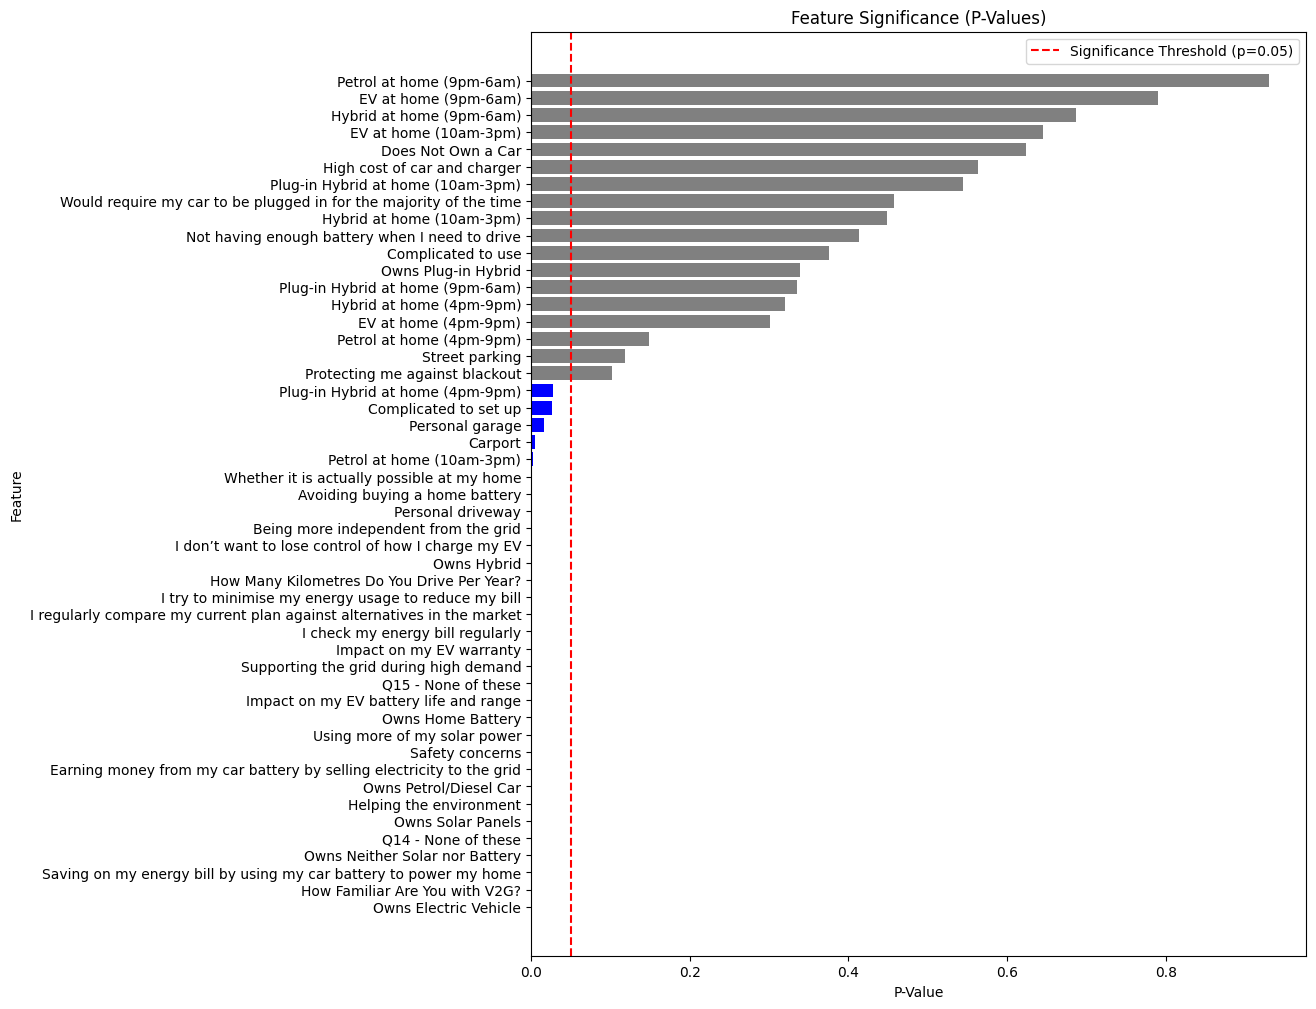

In [26]:
plot_p_value_barh(results_df)

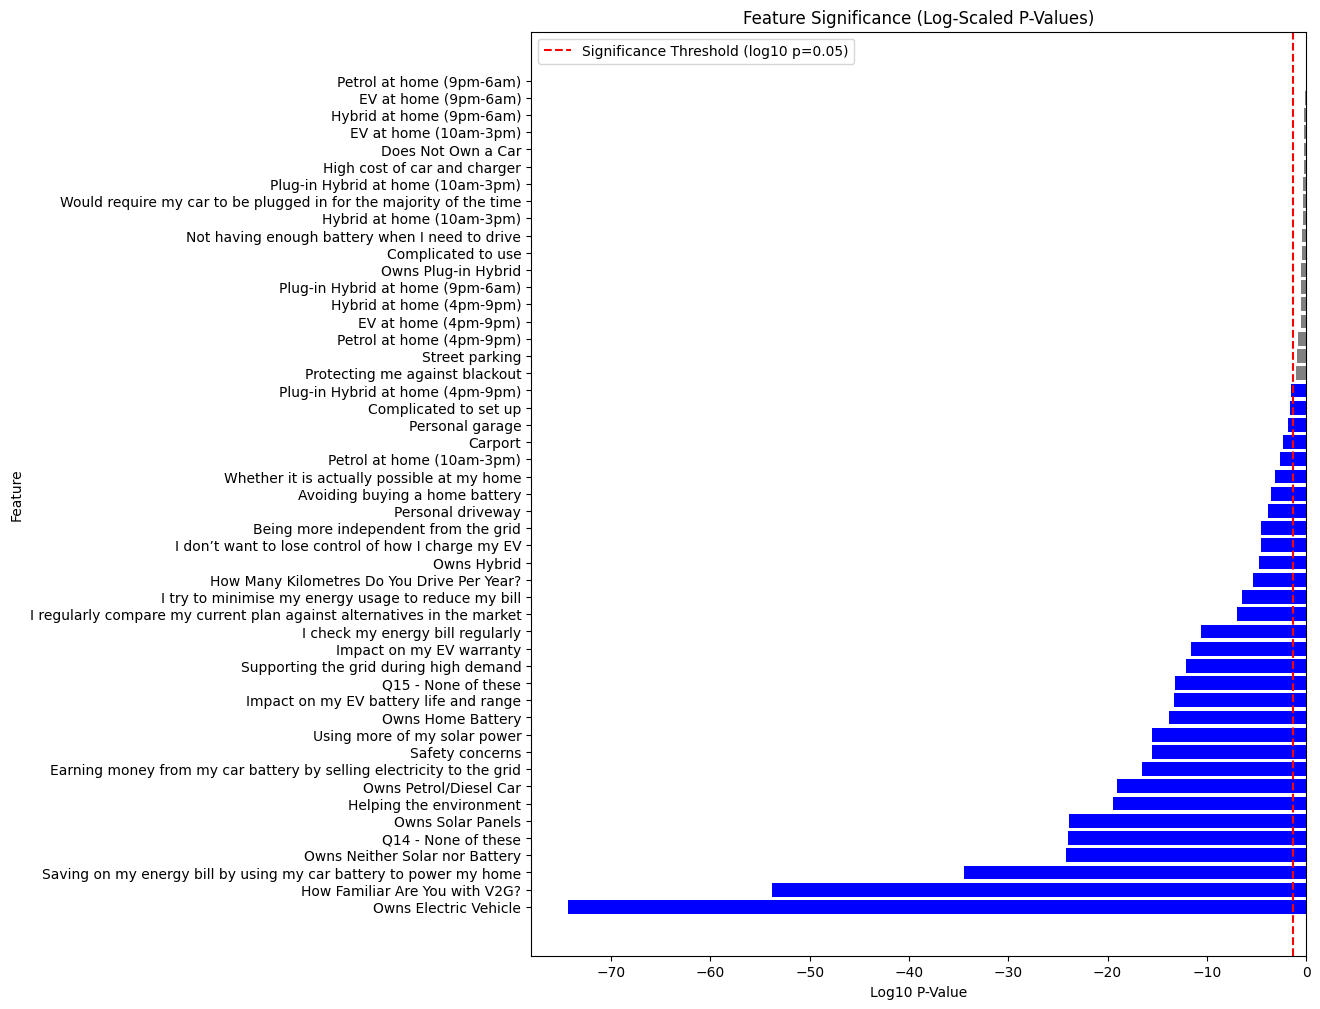

In [27]:
plot_log_p_value_barh(results_df)

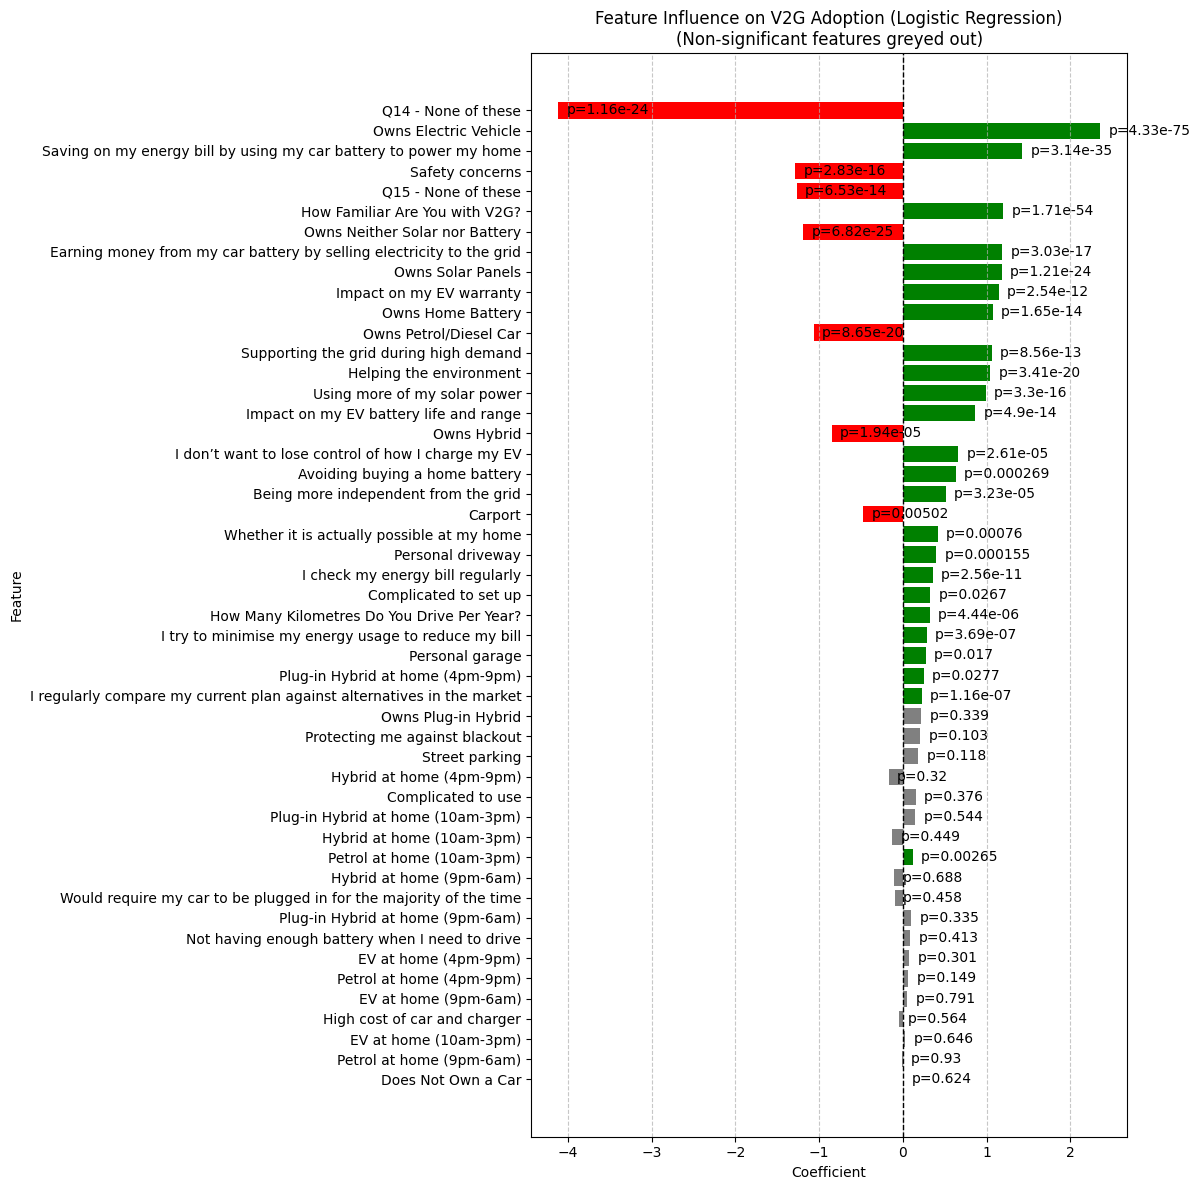

In [28]:
plot_coefficients_significance_barh(results_df, figsize=(12, 12))

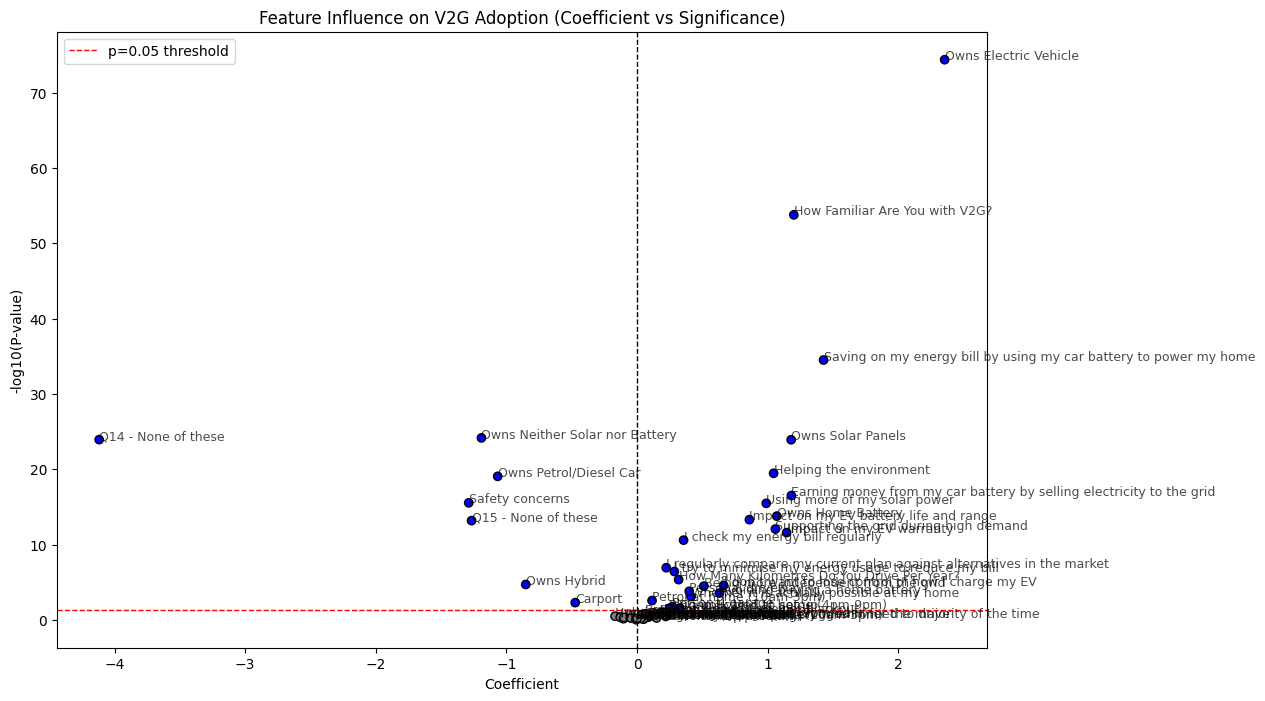

In [29]:
plot_coefficient_vs_significance(results_df)

# 4. Binomial Logistic Regression

## 4.1. Filtering my df based on the previous p-value analysis

In [30]:
columns_of_interest_filtered = filter_significant_features(
    results_df=results_df,
    feature_label_map=feature_label_map,
    columns_of_interest=columns_of_interest,
    target_variable=target_variable
)

Original columns count: 59
Filtered columns count: 32


In [31]:
filtered_df = df[columns_of_interest_filtered]
filtered_df

,Q9,Q2,Q8_1,Q8_2,Q8_99,Q6ax1_1,Q6ax3_2,Q1_1,Q1_2,Q1_4,...,Q15_3,Q15_5,Q15_7,Q15_8,Q15_10,Q15_99,Q7_1,Q7_2,Q7_3,Q10_2
0,Somewhat familiar,"Less than 10,000",1,0,0,3.0,0.0,1,0,0,...,0,1,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
1,Very familiar,"Less than 10,000",1,1,0,5.0,0.0,1,1,0,...,0,0,0,0,0,1,Strongly agree,Strongly agree,Somewhat agree,1
2,Not at all familiar,"20,001-50,000",0,0,1,2.0,0.0,1,0,0,...,0,0,0,0,0,0,Somewhat agree,Somewhat agree,Somewhat agree,0
3,Not at all familiar,"Less than 10,000",0,0,1,0.0,0.0,0,0,1,...,0,1,0,0,0,0,Somewhat disagree,Somewhat disagree,Somewhat agree,0
4,Very familiar,"20,001-50,000",1,1,0,5.0,0.0,1,1,1,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Somewhat agree,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1353,Somewhat familiar,"10,000-20,000",1,1,0,0.0,0.0,0,1,0,...,0,1,1,0,0,0,Strongly agree,Strongly agree,Neither agree nor disagree,1
1354,Somewhat familiar,"Less than 10,000",0,0,1,5.0,0.0,1,0,0,...,0,0,0,1,1,0,Strongly agree,Somewhat agree,Somewhat agree,0
1355,Very familiar,"10,000-20,000",1,0,0,4.0,0.0,1,1,0,...,0,1,1,0,1,0,Strongly agree,Neither agree nor disagree,Neither agree nor disagree,1
1356,Very familiar,"10,000-20,000",0,0,1,0.0,0.0,0,1,0,...,0,0,0,0,1,0,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,1


## 4.2. Running regression

In [32]:
filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)

C:\Users\24417507\AppData\Local\Temp\ipykernel_5932\3615609723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Q6ax1_1'] = filtered_df['Q6ax1_1'].fillna(0)
C:\Users\24417507\AppData\Local\Temp\ipykernel_5932\3615609723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Q6ax3_2'] = filtered_df['Q6ax3_2'].fillna(0)


In [33]:
print("Checking if any feature column is missing data...")
print(filtered_df.isnull().sum())

print("\nChecking unique values in target variable (Q10_2):")
print(filtered_df[target_variable].unique())

print("\nChecking number of non-missing rows in dataset:")
valid_rows = filtered_df.dropna().shape[0]
print(f"Valid rows: {valid_rows} / {df.shape[0]}")


Checking if any feature column is missing data...
Q9         0
Q2         0
Q8_1       0
Q8_2       0
Q8_99      0
Q6ax1_1    0
Q6ax3_2    0
Q1_1       0
Q1_2       0
Q1_4       0
Q3_1       0
Q3_2       0
Q3_3       0
Q14_1      0
Q14_2      0
Q14_3      0
Q14_4      0
Q14_5      0
Q14_6      0
Q14_8      0
Q14_99     0
Q15_2      0
Q15_3      0
Q15_5      0
Q15_7      0
Q15_8      0
Q15_10     0
Q15_99     0
Q7_1       0
Q7_2       0
Q7_3       0
Q10_2      0
dtype: int64

Checking unique values in target variable (Q10_2):
[0 1]

Checking number of non-missing rows in dataset:
Valid rows: 1358 / 1358


In [34]:
# Let's confirm all columns in columns_of_interest_filtered have a transformer
for col in columns_of_interest_filtered:
    transformer_func = TRANSFORMERS_q6a.get(col, fallback_text_to_float)
    print(f"Column {col}: transformer = {transformer_func.__name__ if transformer_func else 'None'}")

Column Q9: transformer = text_to_code_q9
Column Q2: transformer = text_to_code_q2
Column Q8_1: transformer = binary_keep_zero
Column Q8_2: transformer = binary_keep_zero
Column Q8_99: transformer = binary_keep_zero
Column Q6ax1_1: transformer = text_to_code_q6
Column Q6ax3_2: transformer = text_to_code_q6
Column Q1_1: transformer = text_to_code_binary
Column Q1_2: transformer = text_to_code_binary
Column Q1_4: transformer = text_to_code_binary
Column Q3_1: transformer = text_to_code_q3_parking
Column Q3_2: transformer = text_to_code_q3_parking
Column Q3_3: transformer = text_to_code_q3_parking
Column Q14_1: transformer = text_to_code_binary
Column Q14_2: transformer = text_to_code_binary
Column Q14_3: transformer = text_to_code_binary
Column Q14_4: transformer = text_to_code_binary
Column Q14_5: transformer = text_to_code_binary
Column Q14_6: transformer = text_to_code_binary
Column Q14_8: transformer = text_to_code_binary
Column Q14_99: transformer = text_to_code_binary
Column Q15_2: 

In [35]:
model_binary, X_train, y_train, X_test, y_test = build_v2g_model_binary_from_df(
    filtered_df,  
    columns_of_interest_filtered,
    target_variable,  
    TRANSFORMERS_q6a,  
    do_normalize=True,
    test_split_ratio=0.2
)

Unique values in y_train: (array([0, 1]), array([507, 577], dtype=int64))
Unique values in y_test: (array([0, 1]), array([139, 132], dtype=int64))
Train Accuracy: 81.83%
Test Accuracy: 79.34%


# 5. Visualisation of results

## 5.1. Coefficients

In [36]:
# Extract coefficients
coefs_binary = model_binary.coef_[0]  # Shape: (1, n_features), so take [0]

# Create DataFrame for visualization
coefs_binary_df = pd.DataFrame({'Feature': columns_of_interest_filtered, 'Coefficient': coefs_binary})
coefs_binary_df.sort_values(by="Coefficient", ascending=False, inplace=True)
coefs_binary_df["Feature"] = coefs_binary_df["Feature"].map(feature_label_map)

In [37]:
coefs_binary_df

,Feature,Coefficient
8,Owns Electric Vehicle,1.282823
14,Saving on my energy bill by using my car batte...,0.957289
0,How Familiar Are You with V2G?,0.944252
13,Earning money from my car battery by selling e...,0.851008
15,Helping the environment,0.765245
28,I check my energy bill regularly,0.658866
17,Supporting the grid during high demand,0.576524
16,Using more of my solar power,0.568868
19,Avoiding buying a home battery,0.517599
18,Being more independent from the grid,0.463798


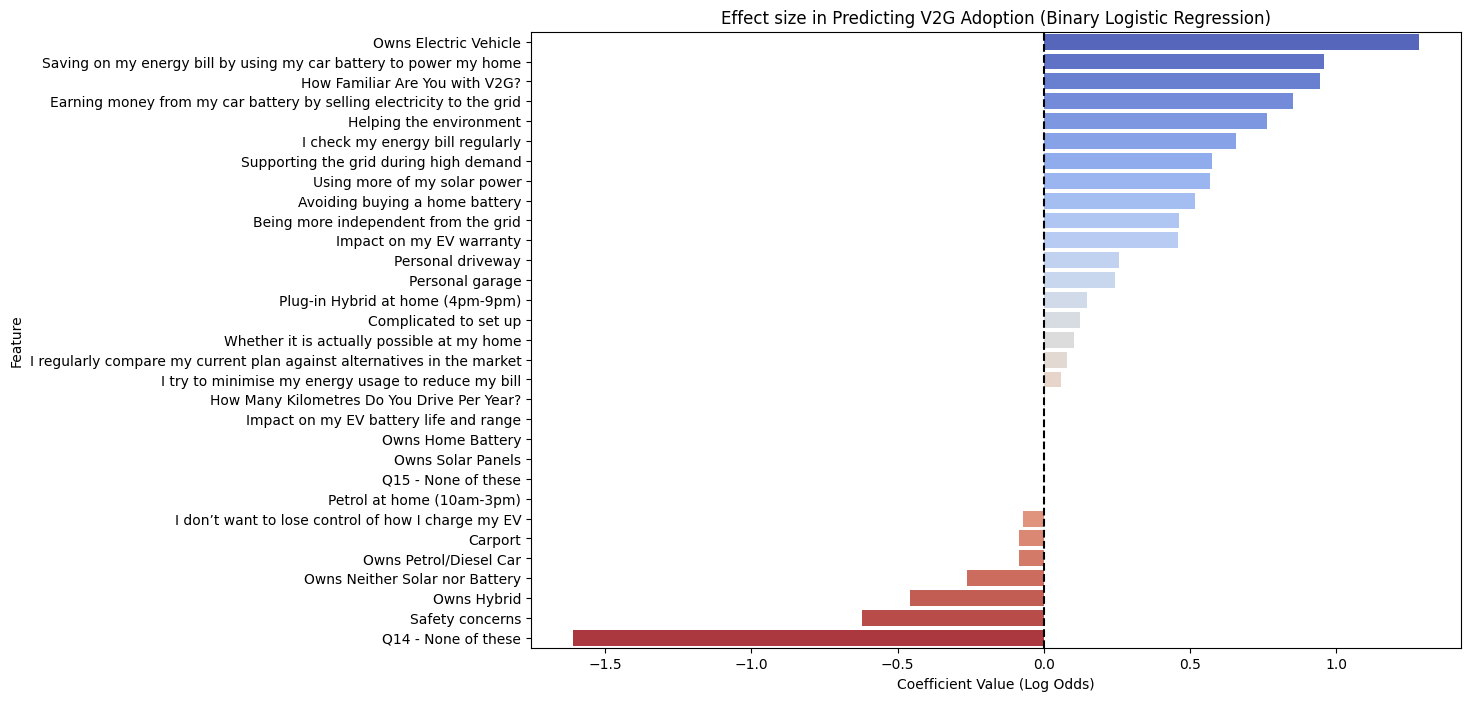

In [38]:
plot_coefficients_barplot(coefs_binary_df)

## 5.2. Odds Ratio

In [39]:
coefs_binary_df["Odds Ratio"] = np.exp(coefs_binary_df["Coefficient"])
coefs_binary_df.sort_values(by="Odds Ratio", ascending=False, inplace=True)

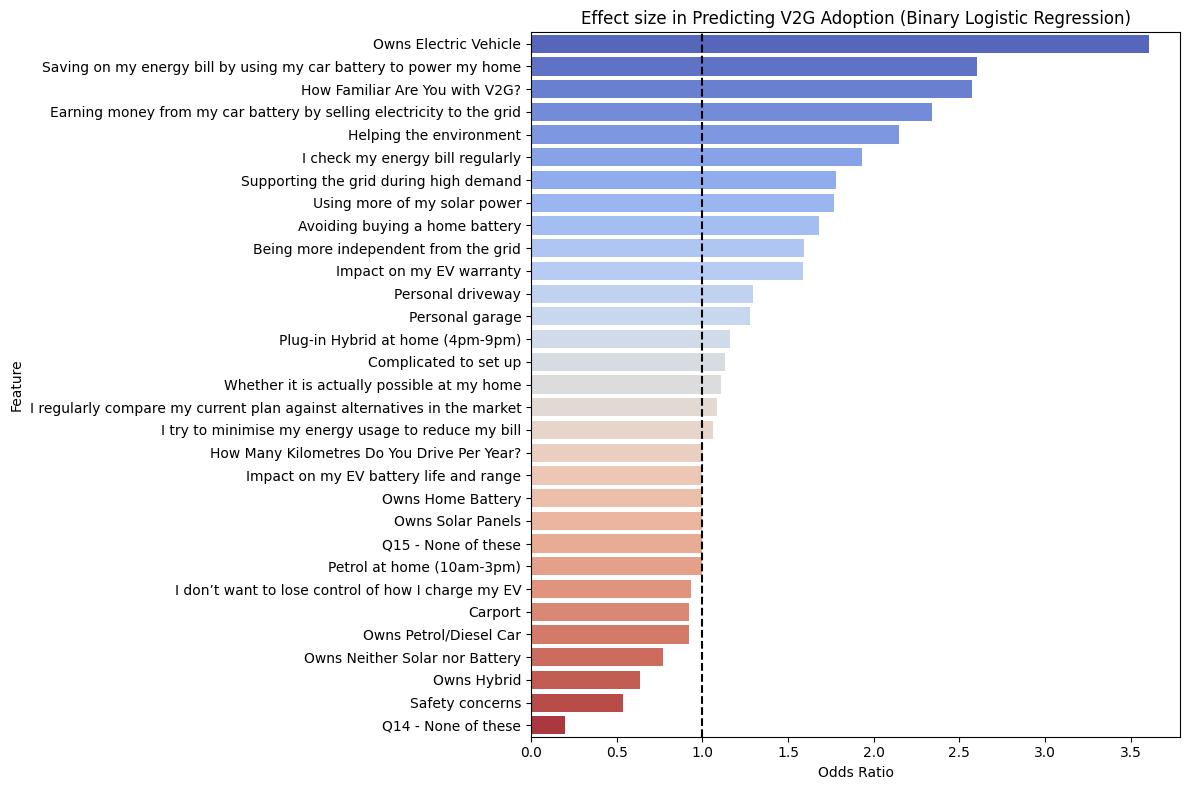

In [40]:
plot_odds_ratios_barplot(coefs_binary_df)

In [41]:
# Sort features by absolute coefficient magnitude for better visualization
coefs_binary_df["abs_coef"] = coefs_binary_df["Coefficient"].abs()
coefs_binary_df = coefs_binary_df.sort_values(by="abs_coef", ascending=False)

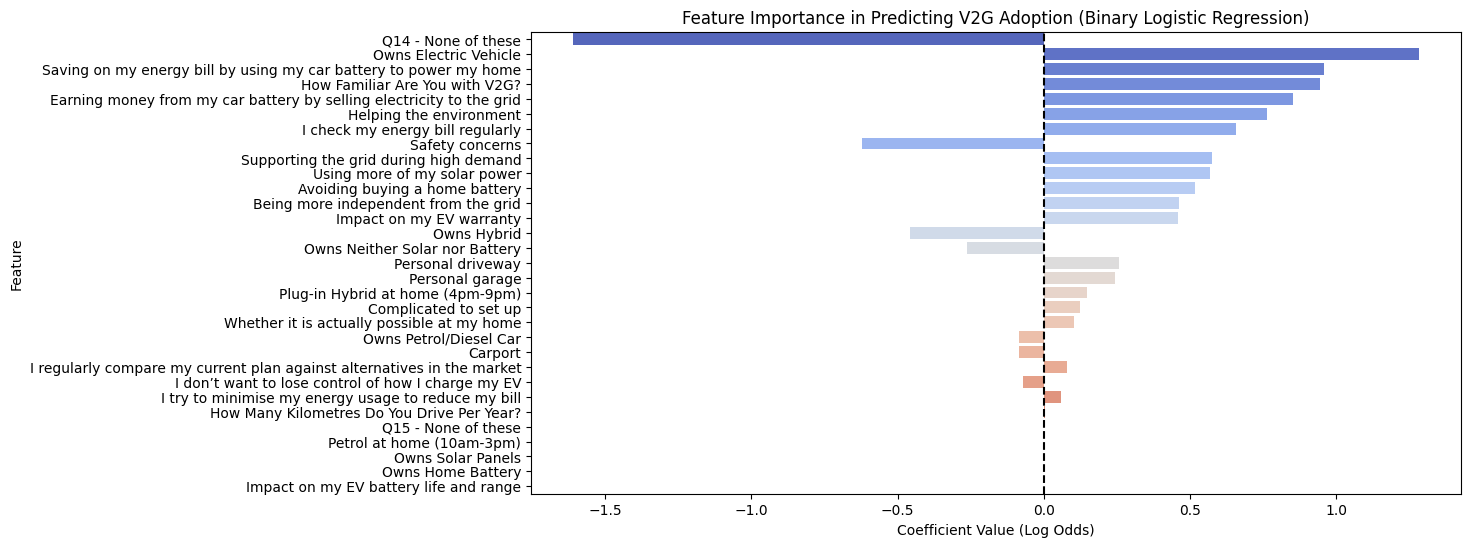

In [42]:
plot_coefficients_by_abs(coefs_binary_df)

In [43]:
# Predict on test data
y_pred_binary = model_binary.predict(X_test)
# Compute accuracy
accuracy_binary = accuracy_score(y_test, y_pred_binary)
print(f"Model Accuracy: {accuracy_binary:.2%}")

Model Accuracy: 79.34%


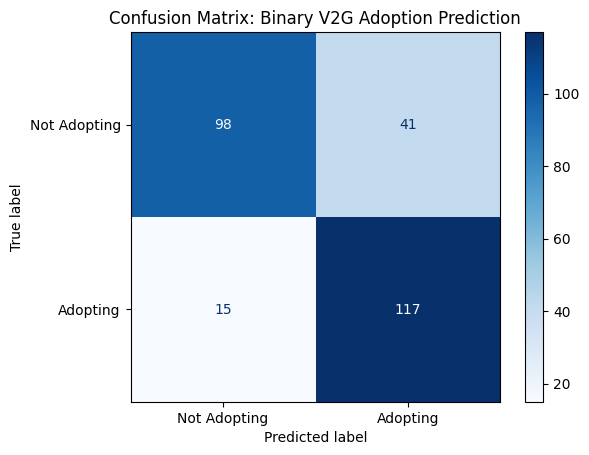

In [44]:
plot_binary_confusion_matrix(y_test, y_pred_binary, labels=["Not Adopting", "Adopting"])

In [45]:
coefs_binary_df

,Feature,Coefficient,Odds Ratio,abs_coef
20,Q14 - None of these,-1.609322,0.200023,1.609322
8,Owns Electric Vehicle,1.282823,3.606806,1.282823
14,Saving on my energy bill by using my car batte...,0.957289,2.604626,0.957289
0,How Familiar Are You with V2G?,0.944252,2.570890,0.944252
13,Earning money from my car battery by selling e...,0.851008,2.342007,0.851008
15,Helping the environment,0.765245,2.149521,0.765245
28,I check my energy bill regularly,0.658866,1.932599,0.658866
21,Safety concerns,-0.622608,0.536543,0.622608
17,Supporting the grid during high demand,0.576524,1.779840,0.576524
16,Using more of my solar power,0.568868,1.766266,0.568868


# 6. Correlation matrix

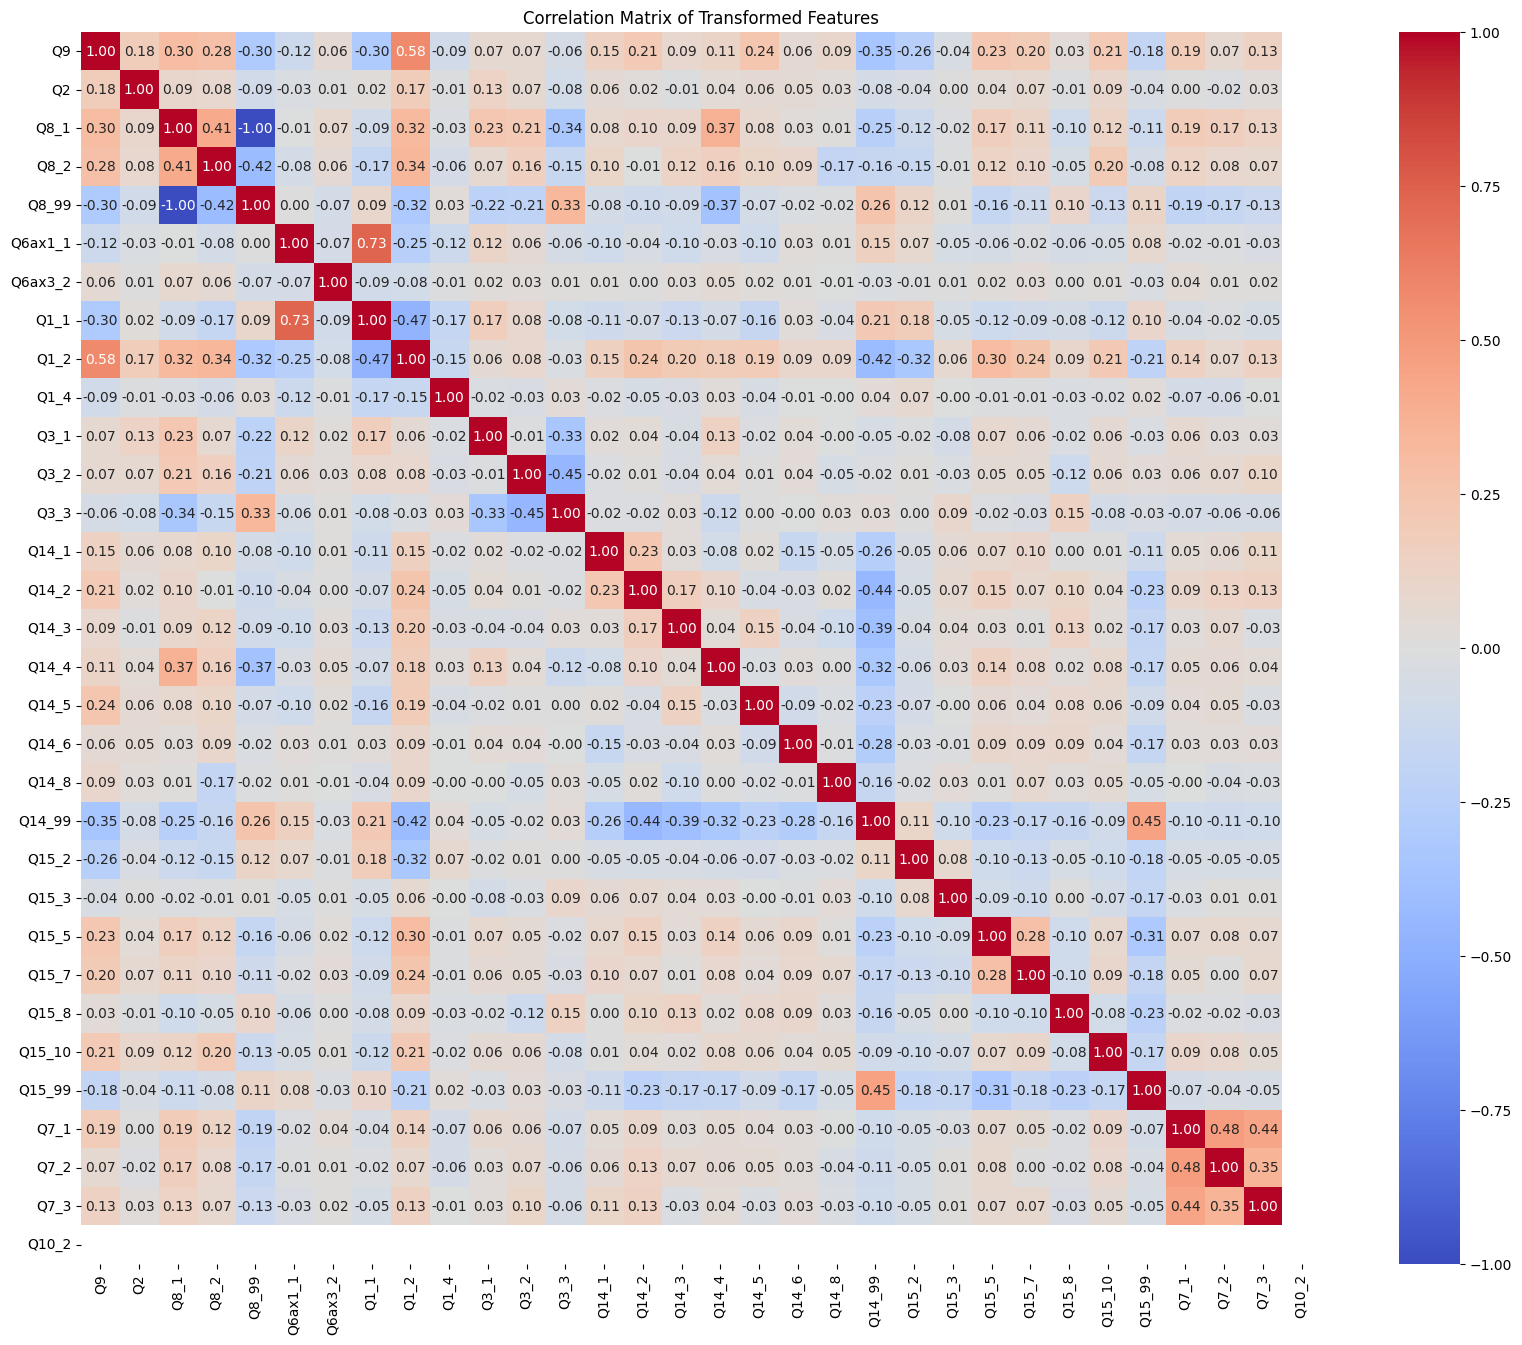

In [46]:
corr_mat = transform_and_plot_correlation(
    filtered_df, 
    TRANSFORMERS_q6a,
    figsize=(20, 16),
    title="Correlation Matrix of Transformed Features"
)

In [47]:
coefs_binary_df.to_csv('./results/binary_coefficients_not_controlled.csv', index=False)

In [54]:
corr_mat['Q8_1'].sort_values(ascending=False)

Q8_1       1.000000
Q8_2       0.407281
Q14_4      0.369276
Q1_2       0.317586
Q9         0.303965
Q3_1       0.228444
Q3_2       0.206627
Q7_1       0.187647
Q7_2       0.171383
Q15_5      0.167840
Q7_3       0.128845
Q15_10     0.123346
Q15_7      0.111071
Q14_2      0.100328
Q2         0.090275
Q14_3      0.089770
Q14_5      0.076247
Q14_1      0.075076
Q6ax3_2    0.074596
Q14_6      0.027342
Q14_8      0.012192
Q6ax1_1   -0.005166
Q15_3     -0.020800
Q1_4      -0.027636
Q1_1      -0.086203
Q15_8     -0.101552
Q15_99    -0.110949
Q15_2     -0.118906
Q14_99    -0.254402
Q3_3      -0.337540
Q8_99     -0.995310
Q10_2           NaN
Name: Q8_1, dtype: float64

In [55]:
corr_mat['Q8_2'].sort_values(ascending=False)

Q8_2       1.000000
Q8_1       0.407281
Q1_2       0.337699
Q9         0.280428
Q15_10     0.200734
Q3_2       0.158083
Q14_4      0.158007
Q7_1       0.122814
Q15_5      0.120020
Q14_3      0.119332
Q14_1      0.104623
Q14_5      0.102188
Q15_7      0.095781
Q14_6      0.087395
Q7_2       0.084761
Q2         0.083885
Q7_3       0.070953
Q3_1       0.068737
Q6ax3_2    0.056096
Q14_2     -0.005942
Q15_3     -0.013750
Q15_8     -0.048831
Q1_4      -0.063052
Q6ax1_1   -0.076580
Q15_99    -0.077261
Q15_2     -0.151609
Q3_3      -0.151792
Q14_99    -0.161037
Q1_1      -0.169908
Q14_8     -0.173428
Q8_99     -0.416259
Q10_2           NaN
Name: Q8_2, dtype: float64